##  Simple Mzlti AI Agent

In [1]:
import os
from typing import TypedDict,Annotated,List,Literal
from langchain_core.messages import BaseMessage,HumanMessage,AIMessage,SystemMessage
from langchain_groq import ChatGroq
from langchain_core.tools import tool
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, END, MessagesState
from langgraph.prebuilt import ToolNode
from langgraph.checkpoint.memory import MemorySaver

In [2]:
import os
from dotenv import load_dotenv

load_dotenv()
os.environ['GROQ_API_KEY']=os.environ['GROQ_API_KEY']

In [ ]:
## Define the state
class AgentState(MessagesState):
    next_agent:str

In [5]:
@tool
def search_web(query:str):
    """Search the web for information"""
    search=TavilySearchResults(max_results=3)
    results=search.invoke(query)
    return str(results)

In [6]:
@tool
def write_summary(content:str):
    """Write a summary of the provided content"""
    summary=f"Summary of findings: \n \n {content[:500]}"
    return summary

In [3]:
llm=ChatGroq(model='openai/gpt-oss-20b')
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x7fb8733f6510>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x7fb8733f7230>, model_name='openai/gpt-oss-20b', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [8]:
## research, writer agent
def researcher_agent(state:AgentState):
    """Researcher agent that searches for information"""
    messages=state['messages']
    system_msg=SystemMessage(content="You are a research assistant. User the search_web to find information about user's request.")
    ## Call LLM with tools
    researcher_llm=llm.bind_tools([search_web])
    response=researcher_llm.invoke([system_msg]+messages)
    return {
        "messages":[response],
        "next_agent":"writer"
    }

def writer_agent(state:AgentState):
    """Writer agent that creates summaries"""
    messages=state['messages']
    system_msg=SystemMessage(content="You are a technical writer. Review the conservation and create a clear, concise summary of the findings.")

    response=llm.invoke([system_msg]+messages)
    return {
        "messages":[response],
        "next_agent":"end"
    }

In [10]:
def execute_tools(state:AgentState):
    messages=state['messages']
    last_message=messages[-1]

    if hasattr(last_message,'tool_calls') and last_message.tool_calls:
        ## create tool node and execute
        tool_node=ToolNode([search_web,write_summary])
        response=tool_node.invoke(state)
        return response
    ## no tools to execute
    return state

In [17]:
def route_researcher(state: AgentState) -> Literal["tools", "writer"]:
    """Route to tools if a tool call is present, otherwise route to the writer."""
    # The last message is the response from the researcher
    last_message = state['messages'][-1]
    
    # Check if the LLM requested a tool call
    if hasattr(last_message, 'tool_calls') and last_message.tool_calls:
        return "tools"
    else:
        return "writer"

def create_minimal_multi_agent():
    """Minimal multi agent system using just LLM calls"""
    ## Build graph
    workflow=StateGraph(AgentState)
    workflow.add_node("researcher",researcher_agent)
    workflow.add_node('tools',execute_tools)
    workflow.add_node("writer",writer_agent)

    workflow.set_entry_point("researcher")
    workflow.add_conditional_edges(
        "researcher",
        route_researcher,
        {"tools": "tools", "writer": "writer"}
    )
    workflow.add_edge("tools","researcher")
    workflow.add_edge("writer",END)
    final_workflow=workflow.compile()

    return final_workflow

In [18]:
final_workflow=create_minimal_multi_agent()

In [20]:
final_workflow.invoke({'messages':"Research about the use case of agentic ai in business"})

/tmp/ipykernel_73797/178234549.py:4: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  search=TavilySearchResults(max_results=3)


{'messages': [HumanMessage(content='Research about the use case of agentic ai in business', additional_kwargs={}, response_metadata={}, id='4a265953-fed2-40e3-bbc6-7f8ae7e05e0d'),
  AIMessage(content='', additional_kwargs={'reasoning_content': 'We need to search web. Use search_web.', 'tool_calls': [{'id': 'fc_b6ba7025-334e-405a-a8e3-c0ee2d282314', 'function': {'arguments': '{"query":"agentic AI use case in business"}', 'name': 'search_web'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 40, 'prompt_tokens': 150, 'total_tokens': 190, 'completion_time': 0.039233746, 'prompt_time': 0.007182021, 'queue_time': 0.085620906, 'total_time': 0.046415767}, 'model_name': 'openai/gpt-oss-20b', 'system_fingerprint': 'fp_80501ff3a1', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--78c61f5f-3482-4f58-80e0-44ade2aeefa6-0', tool_calls=[{'name': 'search_web', 'args': {'query': 'agentic AI use case in business'}, 'id': 'fc_b6ba7025-

In [28]:
response=final_workflow.invoke({'messages': [HumanMessage(content="Research about the use case of agentic ai in business")]})
response['messages'][-1].content

'**Agentic AI in Business – Key Findings**\n\n| Domain | Typical Use Cases | Example Tools/Companies | Business Value |\n|--------|-------------------|------------------------|----------------|\n| **Software Development** | •\u202fCode generation & refactoring<br>•\u202fUnit‑test creation | GitHub Copilot, Amazon CodeWhisperer, OpenAI Codex | 20‑30\u202f% faster feature cycles, reduced debugging |\n| **Human Resources** | •\u202fCandidate screening & interview scheduling<br>•\u202fEmployee onboarding & policy Q&A | IBM Watson Assistant, Microsoft Viva Learning | 43\u202f% of firms use AI agents for HR; cuts staffing needs, speeds onboarding |\n| **Customer Support** | •\u202fIntelligent ticket routing<br>•\u202fMultilingual self‑service bots<br>•\u202fUpsell/cross‑sell recommendations | Moveworks Agentic AI, Zendesk AI Agent | 24‑hour availability, higher CSAT, lower resolution times |\n| **Finance & Accounting** | •\u202fExpense‑report validation<br>•\u202fAutomated reconciliation & f

## Supervisor Multiagent

In [31]:
import random
from datetime import datetime
from typing import Any, Dict

class SupervisorState(MessagesState):
    current_agent:str=""
    ## track what agent should do
    task_assignments:Dict[str,List[str]]={}
    ## store outputs from each agent
    agent_outputs:Dict[str,Any]={}
    ## track workflow progress
    workflow_stage:str='initial'
    iteration_count:int=0
    max_iteration:int=10
    final_output:str=""

In [84]:
from operator import add
class SupervisorState(MessagesState):
    next_agent:str=""
    research_data:str=""
    analysis:str=""
    final_report:str=""
    task_complete:bool=False
    current_task:str=""


In [85]:
from langchain_core.prompts import ChatPromptTemplate
def create_supervisor_chain():
    """Create the supervisor decision chain"""
    supervisor_prompt=ChatPromptTemplate.from_messages([
        ("system","""You are a supervisor managing a team of agents:
         1. Researcher - Gathers information and data
         2- Analyst - Analyzes data and provides insights
         3- Writer - Creates reports and summaries
         
         
         Based on the curremt state and conservation, decide which agent should work next.
         If the task is complete, respond with 'DONE'
         
         Current state:
         - Has research data: {has_research}
         - Has analysis: {has_analysis}
         - Has report: {has_report}
         
         Respond with ONLY the agent name (researcher/analyst/writer) or 'Done'.
        """),
            ("human","{task}")
    ])

    return supervisor_prompt | llm

In [86]:
def supervisor_agent(state:SupervisorState):
    """Supervisor decides next agent using Groq LLM"""
    messages=state['messages']
    task=messages[-1].content if messages else 'No task'

    has_research=bool(state.get('research_data',''))
    has_analysis=bool(state.get('analysis',''))
    has_report=bool(state.get('final_report',''))

    ## Get LLM decision
    chain = create_supervisor_chain()
    decision= chain.invoke({'task':task,'has_research':has_research,
                            'has_analysis':has_analysis,'has_report':has_report})
    
    ## Parse decision
    decision_text = decision.content.strip().lower()
    print(decision_text)

    ## Determine next agent
    if "done" in decision_text or has_report:
        next_agent='end'
        supervisor_msg='Supervisor: All tasks complete! Great work team'
    elif 'researcher' in decision_text or not has_research:
        next_agent='researcher'
        supervisor_msg="Supervisor: Let's start with research. Assigning to Researcher..."
    elif 'analyst' in decision_text or (has_research or not has_analysis):
        next_agent='analyst'
        supervisor_msg='Supervisor: Research done. Time for analysis: Assigning to Analyst ...'
    elif 'writer' in decision_text or (has_analysis or not has_report):
        next_agent='writer'
        supervisor_msg="Supervisor: Analysis compelte. Let's create the report. Assigning to writer."
    else:
        next_agent='end'
        supervisor_msg='Supervisor: Task seems complete.'

    return {
        'messages':[AIMessage(content=supervisor_msg)],
        'next_agent':next_agent,
        'current_task':task
    }

In [87]:
def writer_agent(state:SupervisorState):

    research_data=state.get('research_data','')
    analysis = state.get('analysis','')
    task= state.get('current_task','')

    writing_prompt=f"""As a professional writer, create am executive report based on:
    
    Task: {task}
    Research Findings: {research_data[:1000]}
    Analysis: {analysis[:1000]}
    
    Create a well-structured report with:
    1. Executive Summary
    2. Key Findings
    3. Analysis & Insights
    4. Recommendations
    5. Conclusion

    Keep it professional and concise.
    """

    report_response=llm.invoke([HumanMessage(content=writing_prompt)])
    report=report_response.content

    ## create final formatted report
    final_report=f"""
    Final Report 
    {'='*50}
    Generated: {datetime.now().strftime('%Y-%m-%d %H:%M')}
    Topic: {task}
    {'='*50}
    {report}
    {'='*50}
    Report compiled by Multi-Agent AI System powered by Groq
    """

    return {
        'messages':[AIMessage(content='Writer: Report complete! See below for the full document.')],
        'final_report': final_report,
        'next_agent':'supervisor',
        'task_complete':True

    }

In [88]:
def researcher_agent(state:SupervisorState):
    task=state.get('current_task','research_topic')
    ## Create research prompt
    researcher_prompt = f"""As a researcher, provide comprehensive information about: {task}
    
    Include:
    1. Key facts and background
    2. Current trends or developments
    3. Important statistics or data points
    4. Notable examples or case studies
    
    Be concise but thorough."""

    research_response=llm.invoke([HumanMessage(content=researcher_prompt)])
    research_data = research_response.content
    agent_message= f"Researcher: I've completed the research on '{task}'. Key Findings: {research_data} "

    return {
        'messages': [AIMessage(content=agent_message)],
        'research_data':research_data,
        'next_agent':'supervisor'
    }

In [89]:
def analyst_agent(state:SupervisorState):
    """Analyst uses Groq to analyze the research"""
    research_data=state.get('research_data','')
    task=state.get('current_task','')

    analyst_prompt=f"""As a data analyst, analyze research data and provide insights:
     Research Data: {research_data}
     Provide:
     1. Key insights and patterns
     2. Strategic implications
     3. Risks and opportunities
     4. Recommendations
     
     Focus on actionable related to: {task}"""
    
    analysis_response=llm.invoke([HumanMessage(content=analyst_prompt)])
    analysis=analysis_response.content

    agent_message=f"Analyst: I've completed the analyis. Top insights: {analysis[:400]}..."

    return {
        'messages':[AIMessage(content=agent_message)],
        'analysis':analysis,
        'next_agent':'supervisor'
    }

In [90]:
def check_loop_guardrail(state: SupervisorState):
    current_agent_choice = state.get('next_agent')
    last_agent_called = state.get('last_agent')
    call_count = state.get('agent_call_count', 0)

    # Increment count if the supervisor just suggested the same agent again
    if current_agent_choice == last_agent_called:
        state['agent_call_count'] = call_count + 1
        if call_count > 3:  # Hard limit of 3 repeated calls
            print("Guardrail: Forcing FINISH due to repeated agent calls.")
            return 'FINISH'
    else:
        state['agent_call_count'] = 0 # Reset counter if a new agent is called

    return current_agent_choice

In [91]:
def router(state:SupervisorState)-> Literal["supervisor", "researcher", "analyst", "writer", "__end__"]:
    next_agent=state.get('next_agent','supervisor')
    if next_agent == 'end' or state.get('task_complete',False):
        return END
    if next_agent in ['supervisor','researcher','analyst','writer']:
        return next_agent

    return "supervisor"

In [92]:
workflow=StateGraph(SupervisorState)

workflow.add_node('supervisor',supervisor_agent)
workflow.add_node('researcher',researcher_agent)
workflow.add_node('analyst',analyst_agent)
workflow.add_node('writer',writer_agent)

workflow.set_entry_point('supervisor')

## Add routing
for node in ['supervisor','researcher','analyst','writer']:
    workflow.add_conditional_edges(node,router,
                                   {
                                       'supervisor':'supervisor',
                                       'researcher':'researcher',
                                       'analyst':'analyst',
                                       'writer':'writer',
                                       END:END
                                   })
graph=workflow.compile()

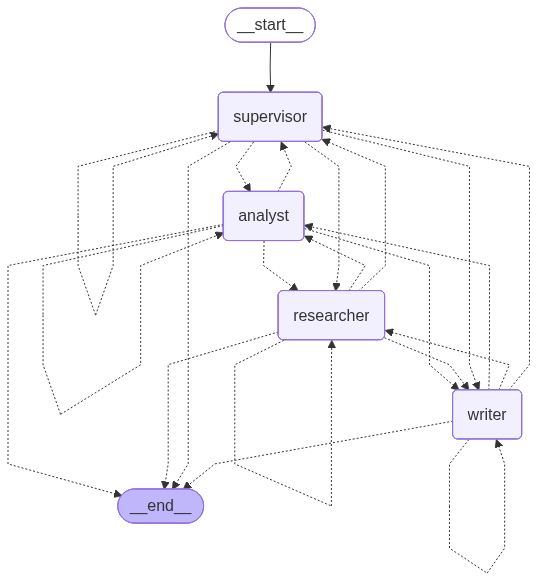

In [93]:
graph

In [94]:
graph.invoke(HumanMessage(content="What are the benefits and risks of AI in healthcare?"))

researcher
analyst
writer
writer
writer


<frozen genericpath>:113: RuntimeWarning: coroutine '_render_mermaid_using_pyppeteer' was never awaited


KeyboardInterrupt: 

In [4]:
from typing import TypedDict, Annotated, List, Literal, Dict, Any
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, SystemMessage
from langgraph.graph import StateGraph, END, MessagesState
from langgraph.checkpoint.memory import MemorySaver
import random
from datetime import datetime

In [5]:
class SupervisorState(MessagesState):
    """State for the multi-agent system"""
    next_agent: str = ""
    research_data: str = ""
    analysis: str = ""
    final_report: str = ""
    task_complete: bool = False
    current_task: str = ""

In [6]:
# ===================================
# Supervisor with Groq LLM
# ===================================
from langchain_core.prompts import ChatPromptTemplate
def create_supervisor_chain():
    """Creates the supervisor decision chain"""
    
    supervisor_prompt = ChatPromptTemplate.from_messages([
        ("system", """You are a supervisor managing a team of agents:
        
1. Researcher - Gathers information and data
2. Analyst - Analyzes data and provides insights  
3. Writer - Creates reports and summaries

Based on the current state and conversation, decide which agent should work next.
If the task is complete, respond with 'DONE'.

Current state:
- Has research data: {has_research}
- Has analysis: {has_analysis}
- Has report: {has_report}

Respond with ONLY the agent name (researcher/analyst/writer) or 'DONE'.
"""),
        ("human", "{task}")
    ])
    
    return supervisor_prompt | llm



In [7]:
def supervisor_agent(state: SupervisorState) -> Dict:
    """Supervisor decides next agent using Groq LLM"""
    
    messages = state["messages"]
    task = messages[-1].content if messages else "No task"
    
    # Check what's been completed
    has_research = bool(state.get("research_data", ""))
    has_analysis = bool(state.get("analysis", ""))
    has_report = bool(state.get("final_report", ""))
    
    # Get LLM decision
    chain = create_supervisor_chain()
    decision = chain.invoke({
        "task": task,
        "has_research": has_research,
        "has_analysis": has_analysis,
        "has_report": has_report
    })
    
    # Parse decision
    decision_text = decision.content.strip().lower()
    print(decision_text)
    
    # Determine next agent
    if "done" in decision_text or has_report:
        next_agent = "end"
        supervisor_msg = "✅ Supervisor: All tasks complete! Great work team."
    elif "researcher" in decision_text or not has_research:
        next_agent = "researcher"
        supervisor_msg = "📋 Supervisor: Let's start with research. Assigning to Researcher..."
    elif "analyst" in decision_text or (has_research and not has_analysis):
        next_agent = "analyst"
        supervisor_msg = "📋 Supervisor: Research done. Time for analysis. Assigning to Analyst..."
    elif "writer" in decision_text or (has_analysis and not has_report):
        next_agent = "writer"
        supervisor_msg = "📋 Supervisor: Analysis complete. Let's create the report. Assigning to Writer..."
    else:
        next_agent = "end"
        supervisor_msg = "✅ Supervisor: Task seems complete."
    
    return {
        "messages": [AIMessage(content=supervisor_msg)],
        "next_agent": next_agent,
        "current_task": task
    }

In [8]:
def researcher_agent(state: SupervisorState) -> Dict:
    """Researcher uses Groq to gather information"""
    
    task = state.get("current_task", "research topic")
    
    # Create research prompt
    research_prompt = f"""As a research specialist, provide comprehensive information about: {task}

    Include:
    1. Key facts and background
    2. Current trends or developments
    3. Important statistics or data points
    4. Notable examples or case studies
    
    Be concise but thorough."""
    
    # Get research from LLM
    research_response = llm.invoke([HumanMessage(content=research_prompt)])
    research_data = research_response.content
    
    # Create agent message
    agent_message = f"🔍 Researcher: I've completed the research on '{task}'.\n\nKey findings:\n{research_data[:500]}..."
    
    return {
        "messages": [AIMessage(content=agent_message)],
        "research_data": research_data,
        "next_agent": "supervisor"
    }

In [9]:
def analyst_agent(state: SupervisorState) -> Dict:
    """Analyst uses Groq to analyze the research"""
    
    research_data = state.get("research_data", "")
    task = state.get("current_task", "")
    
    # Create analysis prompt
    analysis_prompt = f"""As a data analyst, analyze this research data and provide insights:

Research Data:
{research_data}

Provide:
1. Key insights and patterns
2. Strategic implications
3. Risks and opportunities
4. Recommendations

Focus on actionable insights related to: {task}"""
    
    # Get analysis from LLM
    analysis_response = llm.invoke([HumanMessage(content=analysis_prompt)])
    analysis = analysis_response.content
    
    # Create agent message
    agent_message = f"📊 Analyst: I've completed the analysis.\n\nTop insights:\n{analysis[:400]}..."
    
    return {
        "messages": [AIMessage(content=agent_message)],
        "analysis": analysis,
        "next_agent": "supervisor"
    }


In [10]:
def writer_agent(state: SupervisorState) -> Dict:
    """Writer uses Groq to create final report"""
    
    research_data = state.get("research_data", "")
    analysis = state.get("analysis", "")
    task = state.get("current_task", "")
    
    # Create writing prompt
    writing_prompt = f"""As a professional writer, create an executive report based on:

Task: {task}

Research Findings:
{research_data[:1000]}

Analysis:
{analysis[:1000]}

Create a well-structured report with:
1. Executive Summary
2. Key Findings  
3. Analysis & Insights
4. Recommendations
5. Conclusion

Keep it professional and concise."""
    
    # Get report from LLM
    report_response = llm.invoke([HumanMessage(content=writing_prompt)])
    report = report_response.content
    
    # Create final formatted report
    final_report = f"""
📄 FINAL REPORT
{'='*50}
Generated: {datetime.now().strftime('%Y-%m-%d %H:%M')}
Topic: {task}
{'='*50}
{report}

{'='*50}
Report compiled by Multi-Agent AI System powered by Groq
"""
    
    return {
        "messages": [AIMessage(content=f"✍️ Writer: Report complete! See below for the full document.")],
        "final_report": final_report,
        "next_agent": "supervisor",
        "task_complete": True
    }

In [11]:
def router(state: SupervisorState) -> Literal["supervisor", "researcher", "analyst", "writer", "__end__"]:
    """Routes to next agent based on state"""
    
    next_agent = state.get("next_agent", "supervisor")
    
    if next_agent == "end" or state.get("task_complete", False):
        return END
        
    if next_agent in ["supervisor", "researcher", "analyst", "writer"]:
        return next_agent
        
    return "supervisor"

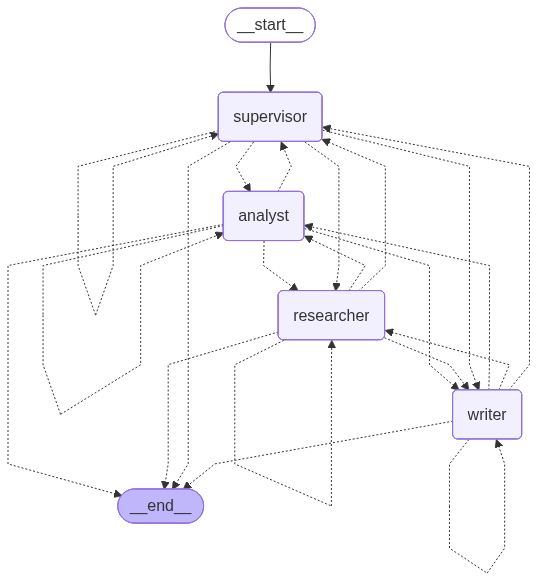

In [12]:
workflow = StateGraph(SupervisorState)

# Add nodes
workflow.add_node("supervisor", supervisor_agent)
workflow.add_node("researcher", researcher_agent)
workflow.add_node("analyst", analyst_agent)
workflow.add_node("writer", writer_agent)

# Set entry point
workflow.set_entry_point("supervisor")

# Add routing
for node in ["supervisor", "researcher", "analyst", "writer"]:
    workflow.add_conditional_edges(
        node,
        router,
        {
            "supervisor": "supervisor",
            "researcher": "researcher",
            "analyst": "analyst",
            "writer": "writer",
            END: END
        }
    )

graph=workflow.compile()
graph

In [13]:
response=graph.invoke(HumanMessage(content="Reasearch about the usecase of agentic ai in business"))


researcher
analyst
writer


In [14]:
response

{'messages': [AIMessage(content="📋 Supervisor: Let's start with research. Assigning to Researcher...", additional_kwargs={}, response_metadata={}, id='196abfe4-8152-462b-9ec7-ae985c320dda'),
  AIMessage(content="🔍 Researcher: I've completed the research on 'No task'.\n\nKey findings:\nI’m happy to help, but I’m not sure what “No task” refers to. Could you let me know which topic or area you’d like me to research? Once I have that, I’ll provide the key facts, background, current trends, statistics, and notable examples as requested....", additional_kwargs={}, response_metadata={}, id='e98ee026-326e-4483-80c6-8858b43af5a1'),
  AIMessage(content='📋 Supervisor: Research done. Time for analysis. Assigning to Analyst...', additional_kwargs={}, response_metadata={}, id='2d08f6ba-13ab-4bd8-b972-964adf90bd33'),
  AIMessage(content="📊 Analyst: I've completed the analysis.\n\nTop insights:\n**Analysis of the “research data” provided**\n\n| # | Observation | Why it matters |\n|---|-------------|--

In [16]:
response['final_report']

"\n📄 FINAL REPORT\n==================================================\nGenerated: 2025-10-07 21:23\nTopic: 📊 Analyst: I've completed the analysis.\n\nTop insights:\n**Analysis of the “research data” provided**\n\n| # | Observation | Why it matters |\n|---|-------------|----------------|\n| 1 | The text is a *generic response* from an assistant, not substantive research findings | Indicates the data set is **incomplete** and lacks content to analyze. |\n| 2 | The phrase “No task” is used as a placeholder for an undefined research topic | Signals **ambiguity** in th...\n==================================================\n**Executive Report – Analysis of the “Research Data” Set**  \n*Prepared for: Senior Leadership Team*  \n*Date: 7\u202fOct\u202f2025*  \n\n---\n\n### 1. Executive Summary  \nThe analyst’s review of the supplied “research data” revealed that the dataset is essentially a placeholder response from an AI assistant, containing no substantive findings. Key observations indicate